In [7]:
from torch.utils.data import Dataset
import torch
from torchvision import datasets
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.utils.data as data
import torchvision
import torch.optim as optim
import torch.nn as nn

In [17]:
# test class ResNet34 
# test the load function and the save function
from model import models
import os
os.mkdir("./temp0")
resnet34 = models.Resnet34(num_classes=10)
resnet34.save("./results")
resnet34.num_classes = 100
weight_before = resnet34.state_dict()["net.conv1.weight"]
resnet34.load("./results")
weight_after = resnet34.state_dict()["net.conv1.weight"]
os.rmdir("./temp0")
print(torch.equal(weight_after,weight_before))
print(resnet34.parameters())

True
<generator object Module.parameters at 0x7a0b7a61f920>


In [3]:
# test create_optimizer function in model_utils.py
from model import model_utils
from model import models
resnet34 = models.Resnet34(num_classes=10)
optimizer,scheduler = model_utils.create_optim_by_name(resnet34.parameters(),optim_name="SGD",optim_hyper_params={"lr":0.01,"momentum":0.1})

100%|███████████████████████| 170498071/170498071 [00:08<00:00, 20982370.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

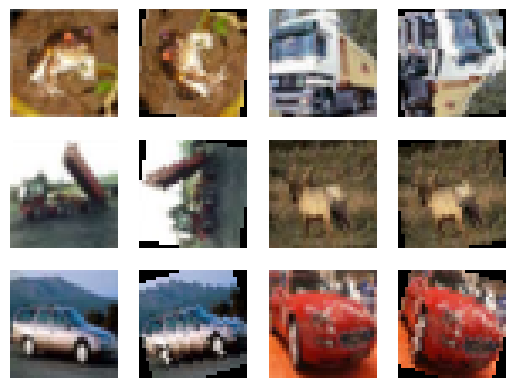

In [5]:
t = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=t)
imgs = [train_dataset[i][0] for i in range(12)]
r = transforms.RandomRotation(90)
imgs = []
for i in range(6):
   imgs.append(train_dataset[i][0]) 
   imgs.append(r(train_dataset[i][0]))
show_images(imgs,3,4)

In [6]:
class AugumentationTransformations(object):
    '''
    for image augumentation
    '''
    def __init__(self, my_transforms, n_views=2):
        '''
        --args:
        my_transforms: torchvison.transforms object that transforms the image
        n_views: the number of transfomed images augmented for each orginal image
        '''
        self._transforms = my_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self._transforms(x) for i in range(self.n_views)]


In [7]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor()
                                         ])

In [8]:
train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=AugumentationTransformations(contrast_transforms, n_views=3))
loader = data.DataLoader(train_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


tensor([6, 9, 9, 4, 6, 9, 9, 4, 6, 9, 9, 4])
torch.Size([4])


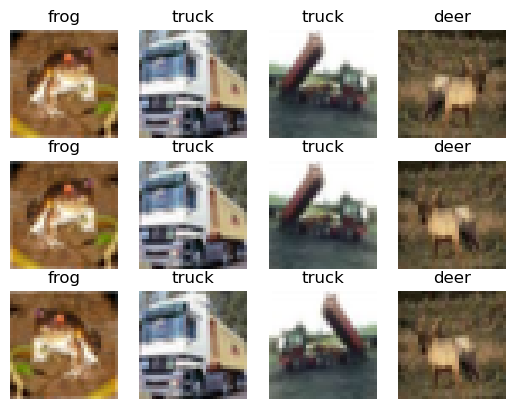

In [11]:
x,y = next(iter(loader))
classes = get_cifar10_classes()
imgs,labels = [],[]
for i in range(3):
    for j in range(4):
        imgs.append(x[i][j,:,:])
        labels.append(classes[y[j]])
show_images(imgs,3,4,labels)
print(y.repeat(3))
print(y.shape)

(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

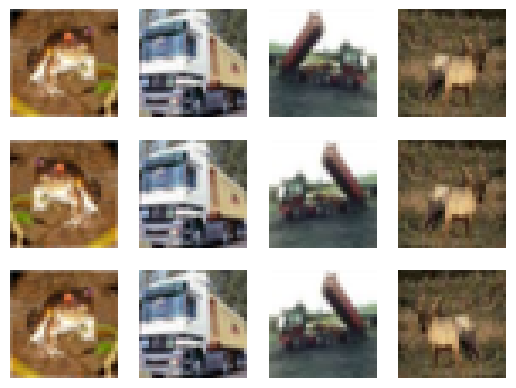

In [10]:
xx = torch.cat(x,dim=0)
imgs = []
for i in range(12):
    imgs.append(xx[i,:,:])
show_images(imgs,3,4)

Files already downloaded and verified
torch.Size([64, 3, 32, 32])


(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'bird'}>,
         <Axes: title={'center': 'bird'}>,
         <Axes: title={'center': 'horse'}>],
        [<Axes: title={'center': 'dog'}>, <Axes: title={'center': 'dog'}>,
         <Axes: title={'center': 'airplane'}>]], dtype=object))

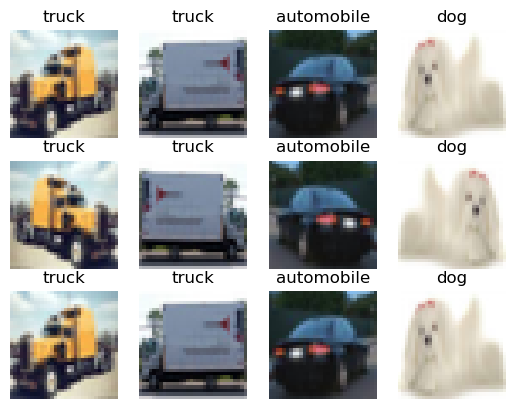

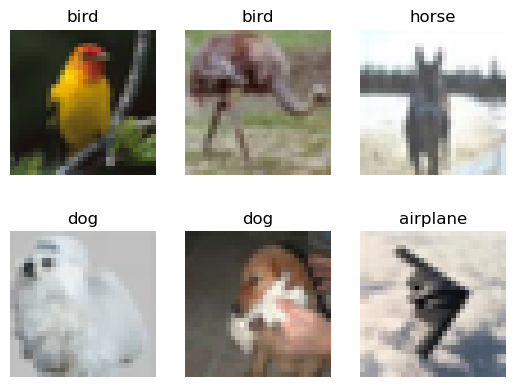

In [20]:
class WrappedDataset(Dataset):
    def __init__(self, dataset, transform=None, n_views = 1):
        self.dataset = dataset
        self.transform = transform
        self.n_views = n_views
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = [self.transform(x) for i in range(self.n_views)]
            y = [y for i in range(self.n_views)]
        return x, y
        
    def __len__(self):
        return len(self.dataset)

train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=None)
_train_set, _val_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_set = WrappedDataset(_train_set,contrast_transforms, n_views=3)
val_set = WrappedDataset(_val_set,transforms.ToTensor())

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False)

x,y = next(iter(train_loader))
imgs,labels = [],[]
for i in range(3):
    for j in range(4):
        imgs.append(x[i][j,:,:])
        labels.append(classes[y[i][j]])
show_images(imgs,3,4,labels)

x,y = next(iter(val_loader))
print(x[0].shape)
imgs = [x[0][i,:,:] for i in range(6)]
labels = [classes[y[0][i]] for i in range(6)]
show_images(imgs,2,3,labels)

In [21]:
# initialize resnet
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
net = torchvision.models.resnet18(num_classes=10) #.to(device) 
optimizer = optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
print(x[0].shape)
net(x[0]).shape

torch.Size([64, 3, 32, 32])


torch.Size([64, 10])

In [13]:
def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0., 0
    for imgs,labels in data_loader:
        imgs, labels = imgs[0].to(device), labels[0].to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [15]:
# train a model
n_views = 3
batch_size = 4
n_epoch = 10
for epoch in range(n_epoch):
    n_true,n_sample = 0,0
    for imgs,labels in train_loader:
        net.train()
        imgs = torch.cat(imgs,dim=0)
        labels = torch.cat(labels,dim=0)
        imgs,labels = imgs.to(device),labels.to(device)
        optimizer.zero_grad()
        # for supervised learning
        preds = net(imgs)
        loss = loss_fn(preds,labels)
        loss.backward()
        optimizer.step()
        n_true += (torch.argmax(preds,dim=1) == labels).sum()
        n_sample += labels.size()[0]
    train_acc = n_true/n_sample
    print("epoch={},training accuracy is {:.3f}\n".format(epoch,train_acc))
    test_acc = test_model(net,val_loader)
        
        
        

epoch=0,training accuracy is 0.366



KeyboardInterrupt: 

In [5]:
x = torch.rand(3,4)
print(x)

tensor([[0.2371, 0.5395, 0.4386, 0.8932],
        [0.2327, 0.9165, 0.6180, 0.4897],
        [0.1577, 0.8813, 0.8943, 0.0378]])


In [33]:
_,ind = x.topk(2,dim=1)
print(ind)

tensor([[2, 3],
        [2, 0],
        [2, 3]])


In [39]:
label = torch.tensor([1,2,3])
ll = label.view(-1,1).expand(3,2)
print((ll == ind).float().sum(dim=1).mean())

tensor(0.6667)


285997696
285997696
285997696
tensor([[100.0000,   0.6151]])
tensor([[  0.5257,   0.1805,   0.8650,   0.8362],
        [  0.5472, 100.0000,   0.6151,   0.2231],
        [  0.6552,   0.4414,   0.8114,   0.7975]])


In [52]:
x = [0.0 for i in range(3)]
print(x)

[0.0, 0.0, 0.0]


In [7]:
sgd = optim.SGD
print(sgd)
s = sgd([x],lr= 0.1)

<class 'torch.optim.sgd.SGD'>


In [9]:
torch.save(s.state_dict(),'./test_optim.tar')

In [13]:
s = sgd([x],**{'lr':1000})
state_dict = torch.load('./test_optim.tar')
s.load_state_dict(state_dict)
print(s)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [7]:
a = torch.rand(2,3)
b = torch.rand(2,3)
print(a)
print(b)
c = torch.cat((a,b))
print(c)
a[1,1] = 100000
print(c)
print(a)

tensor([[0.6418, 0.4234, 0.1119],
        [0.1894, 0.0240, 0.7945]])
tensor([[0.9058, 0.7482, 0.5594],
        [0.7026, 0.3103, 0.8481]])
tensor([[0.6418, 0.4234, 0.1119],
        [0.1894, 0.0240, 0.7945],
        [0.9058, 0.7482, 0.5594],
        [0.7026, 0.3103, 0.8481]])
tensor([[0.6418, 0.4234, 0.1119],
        [0.1894, 0.0240, 0.7945],
        [0.9058, 0.7482, 0.5594],
        [0.7026, 0.3103, 0.8481]])
tensor([[6.4175e-01, 4.2338e-01, 1.1188e-01],
        [1.8940e-01, 1.0000e+05, 7.9454e-01]])


In [8]:
a = [1,2,3]
b = a
b[1] = 1000
print(a)

[1, 1000, 3]
